[[694, 1], [1416, 1], [1779, 1], [2342, 1]]
[[5366, 1], [195, 2], [286, 3]]
[[8, 1], [9, 3], [12, 7], [33, 8], [40, 9], [41, 11], [3, 18], [11, 19], [17, 20], [51, 21]]
[[462, 5], [107, 23], [291, 28], [90, 29], [118, 30], [231, 31], [181, 33], [218, 35], [46, 36], [72, 38], [211, 41], [229, 42]]
No subject data found for Follower ID 9 and Run Index 3.
No data found for Follower ID 9 and Run Index 3. Skipping...
No subject data found for Follower ID 33 and Run Index 8.
No data found for Follower ID 33 and Run Index 8. Skipping...
No subject data found for Follower ID 41 and Run Index 11.
No data found for Follower ID 41 and Run Index 11. Skipping...
No subject data found for Follower ID 3 and Run Index 18.
No data found for Follower ID 3 and Run Index 18. Skipping...
No subject data found for Follower ID 11 and Run Index 19.
No data found for Follower ID 11 and Run Index 19. Skipping...
No subject data found for Follower ID 17 and Run Index 20.
No data found for Follower ID 17 and Run 

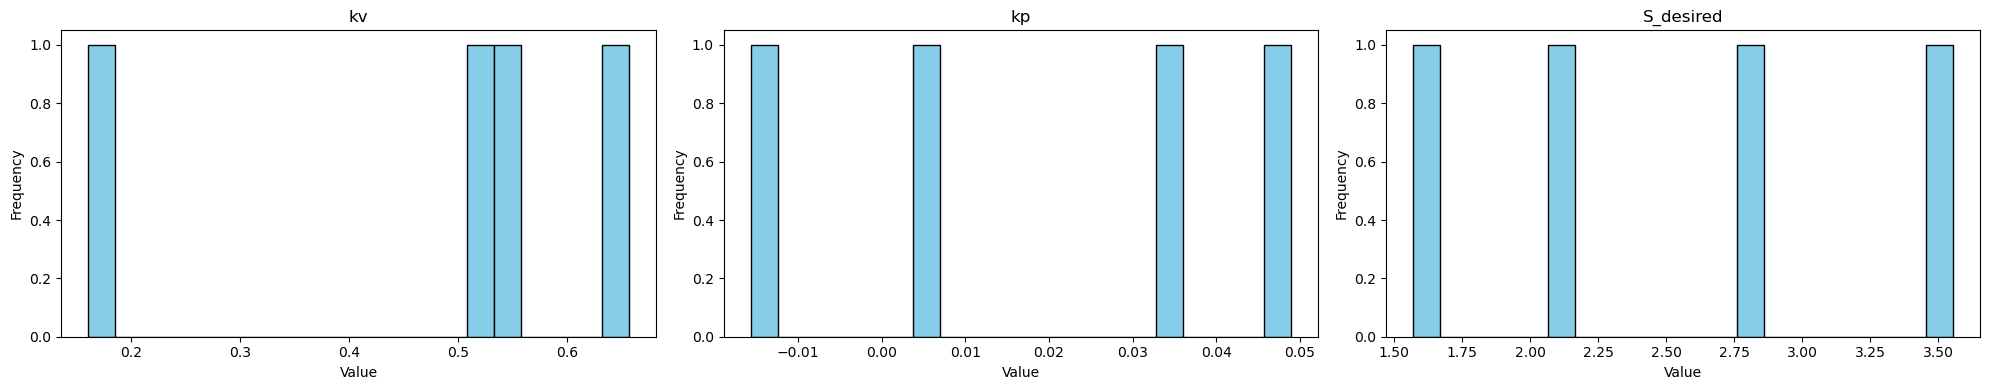

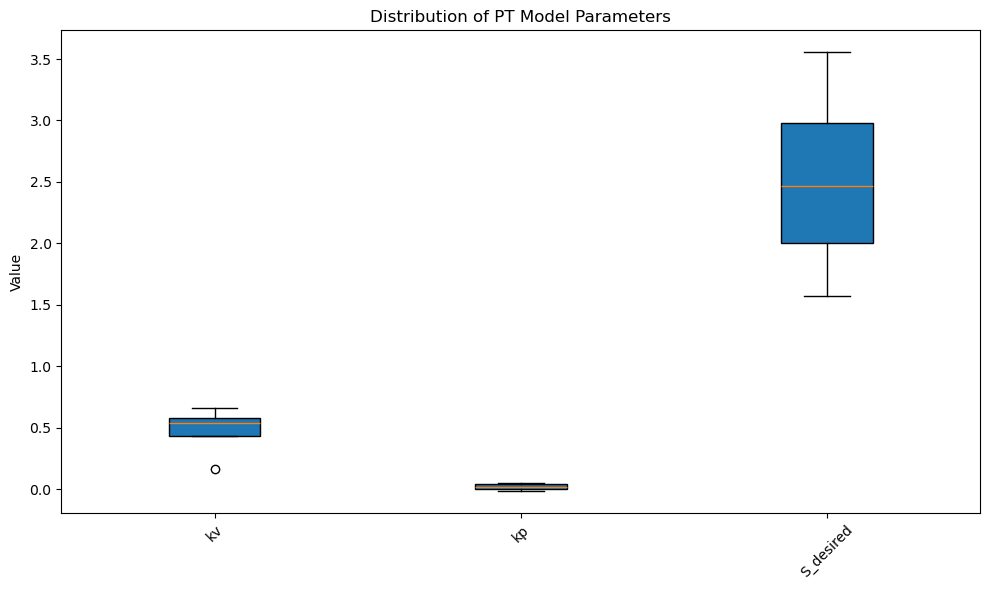

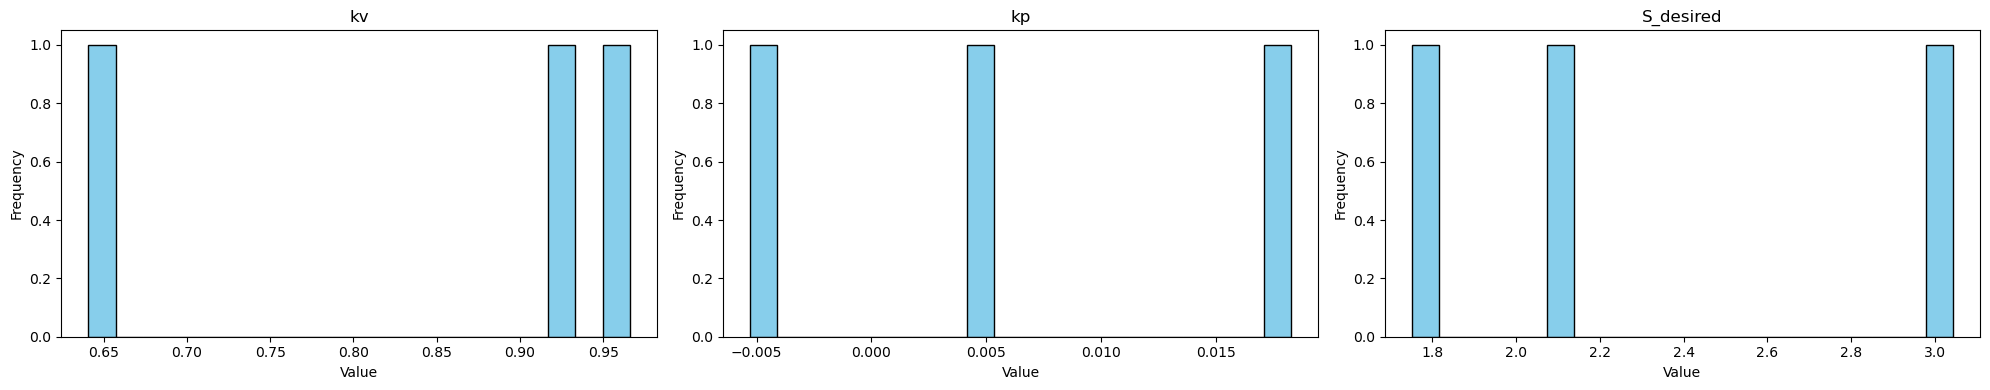

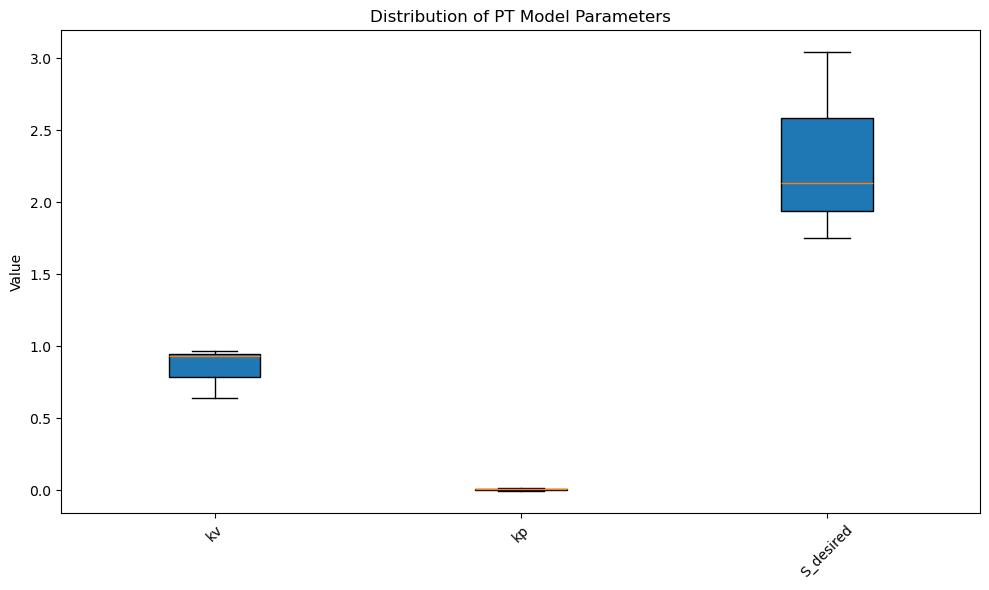

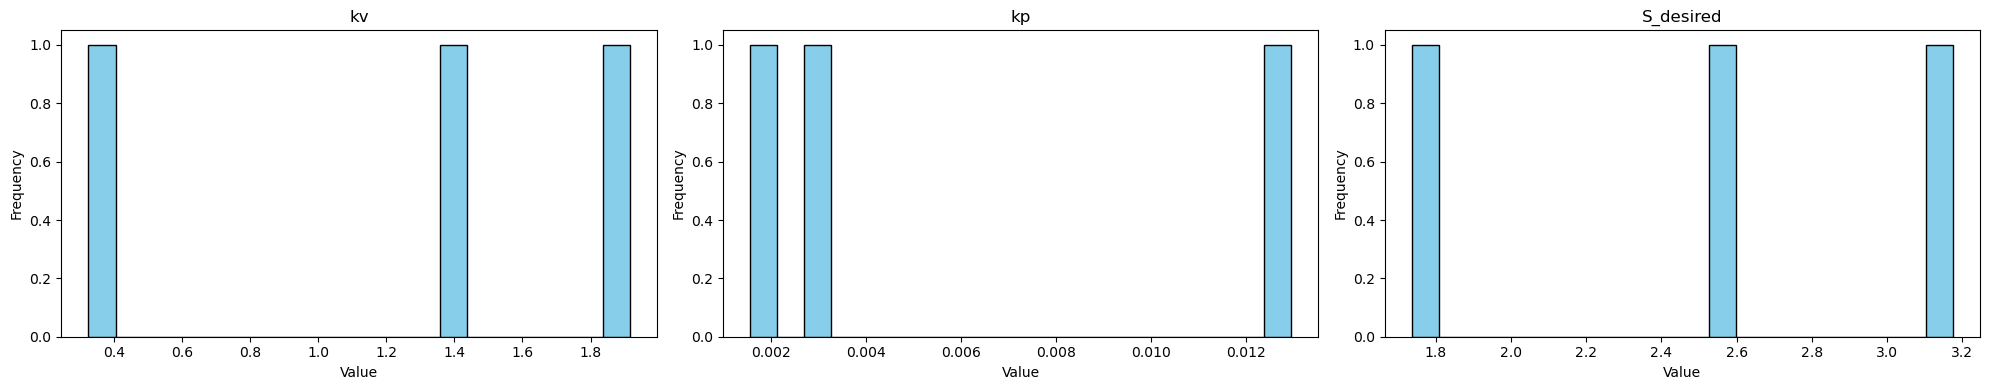

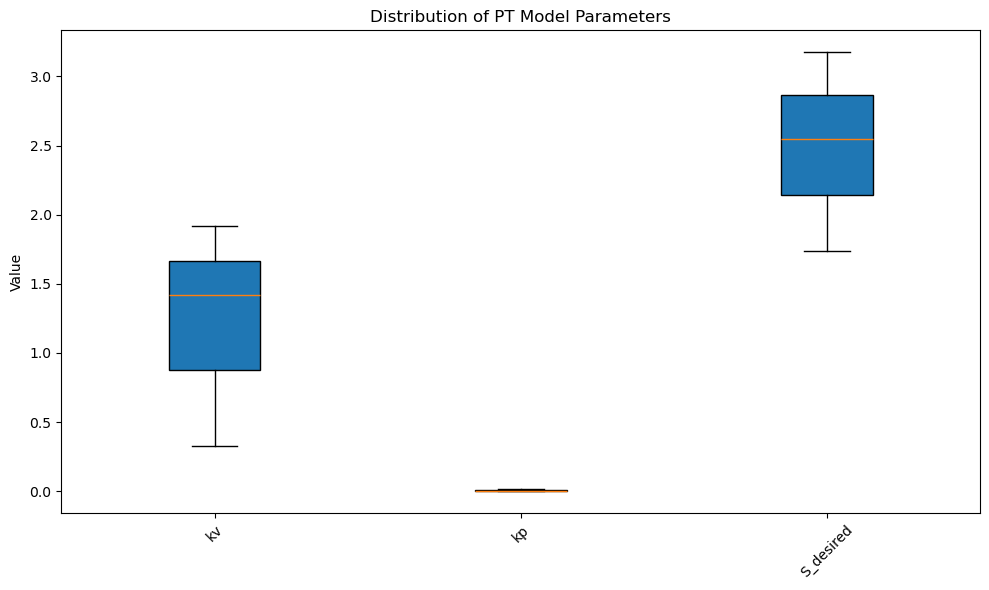

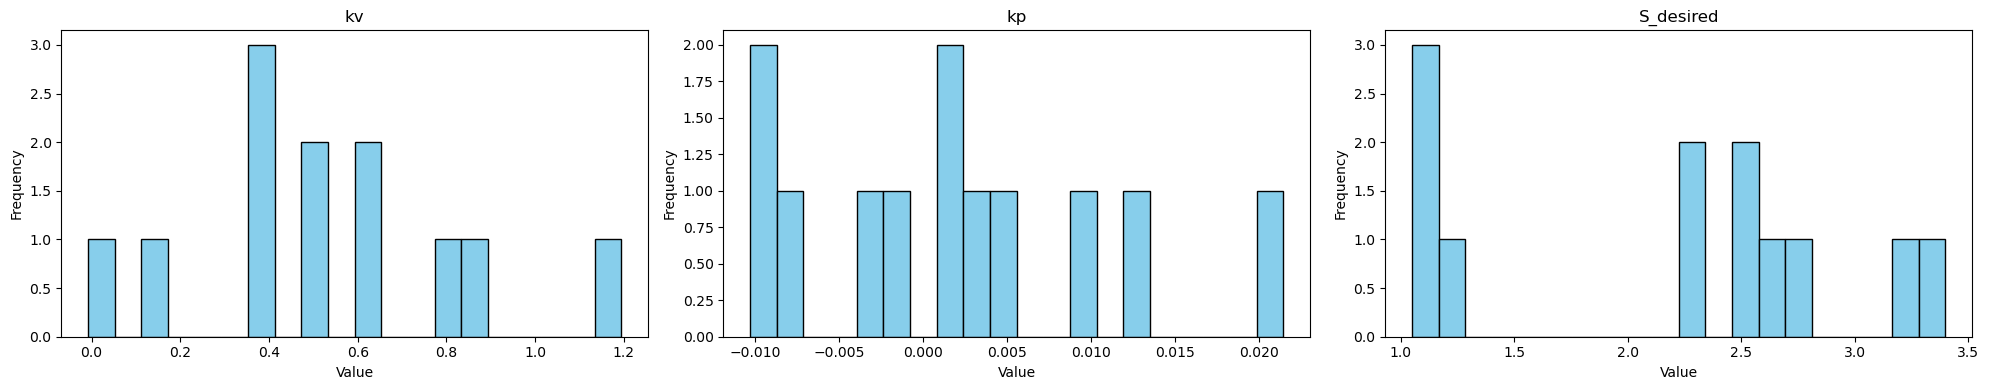

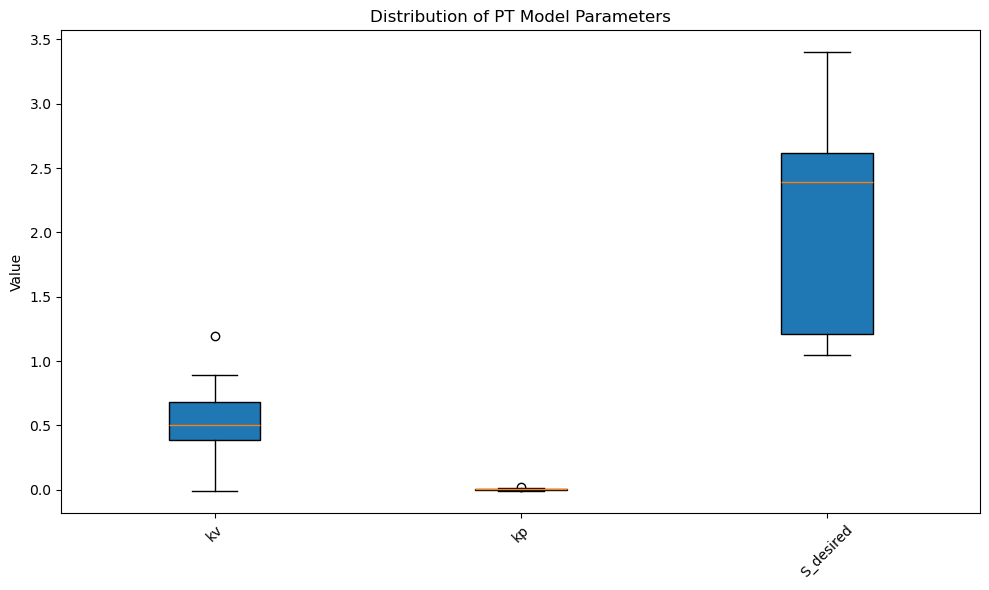

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import math
from scipy.stats import norm
import os
 


datasets = {
"df395": "TGSIM/I395_Trajectories.csv",
"df9094": "TGSIM/I90_I94_Moving_Trajectories.csv",
"df294l1": "TGSIM/I294_L1_Trajectories.csv",
"df294l2": "TGSIM/I294_L2_Trajectories.csv"
}

 

groups = {
    "df395": ["I395_A"],
    "df9094": ["I9094_A"],
    "df294l1": ["I294l1_A"],
    "df294l2": ["I294l2_A"]
    }


I395_A, I9094_A, I294l1_A, I294l2_A = [], [], [], []


for data_key, data_path in datasets.items():
    temp_df = pd.read_csv(data_path) 
 

    if data_key == 'df395': 
        temp_df_av = temp_df[temp_df['type_most_common'] == 4]
        temp_df_id = temp_df_av['id'].unique()
        temp_df_run_index = temp_df_av['run_index'].values[0]


        for id_val in temp_df_id:
            I395_A.append([id_val,temp_df_run_index])


    elif data_key == 'df9094':
        temp_df_av = temp_df[temp_df['av'] == 'yes']
        temp_df_id = temp_df_av['id'].unique()
        temp_df_run_index = temp_df_av['run_index'].unique()
    
      
        for id_val, run_index_val in zip(temp_df_id, temp_df_run_index):
            I9094_A.append([id_val, run_index_val])


    elif data_key == 'df294l1':
        temp_df['acc'] = temp_df['acc'].str.lower()
        temp_df_av = temp_df[temp_df['acc'] == 'yes']
        temp_df_id = temp_df_av['id'].unique()
        temp_df_run_index = temp_df_av['run_index'].unique()


        for id_val, run_index_val in zip(temp_df_id, temp_df_run_index):
            I294l1_A.append([id_val, run_index_val])


    elif data_key == 'df294l2':
        temp_df['acc'] = temp_df['acc'].str.lower()
        temp_df_av = temp_df[temp_df['acc'] == 'yes']
        temp_df_id = temp_df_av['id'].unique()
        temp_df_run_index = temp_df_av['run_index'].unique()


        for id_val, run_index_val in zip(temp_df_id, temp_df_run_index):
            I294l2_A.append([id_val, run_index_val])




print(I395_A)
print(I9094_A)
print(I294l1_A)
print(I294l2_A)



####################### SIMULATION PARAMETERS ##########################################################
population_size = 100  # Keep as is (sufficient for convergence)
num_generations = 100  # Increase for better tuning
mutation_rate = 0.1  # Reduce mutation rate for better stability
 

  
most_leading_leader_id = None   
#################################################################################################################



def find_leader_data(df, follower_id, run_index):
    global most_leading_leader_id
    
    follower_data = df[(df['id'] == follower_id) & (df['run_index'] == run_index)]
    leader_data_dict = {}
    
    for index, row in follower_data.iterrows():
        time = row['time']
        follower_x = row[pos]
        follower_lane = row['lane_kf']
        run_index = row['run_index']

        #find the leader
        leader_data = df[(df['id'] != follower_id) & (df['time'] == time) & (df['lane_kf'] == follower_lane) & (df[pos] > follower_x) & (df['run_index'] == run_index)]
        
        if not leader_data.empty:
            nearest_leader_row = leader_data.loc[leader_data[pos].sub(follower_x).abs().idxmin()]
            
            leader_id = nearest_leader_row['id']
            leader_x_val = nearest_leader_row[pos]
            leader_speed_val = nearest_leader_row['speed_kf']

            if leader_id not in leader_data_dict:
                leader_data_dict[leader_id] = {'time': [], 'x_val': [], 'speed_val': []}

            leader_data_dict[leader_id]['time'].append(time)
            leader_data_dict[leader_id]['x_val'].append(leader_x_val)
            leader_data_dict[leader_id]['speed_val'].append(leader_speed_val)

    if leader_data_dict:
        most_leading_leader_id = max(leader_data_dict, key=lambda x: len(leader_data_dict[x]['time'])) 
        leader_data = leader_data_dict[most_leading_leader_id]
        leader_df = pd.DataFrame({'id': most_leading_leader_id,
                                   'time': leader_data['time'],
                                   pos: leader_data['x_val'],
                                   'speed_kf': leader_data['speed_val'],
                                   'run_index': run_index})
    else:
        leader_df = pd.DataFrame(columns=['id', 'time', pos, 'speed_kf', 'run_index'])
    
 
    return leader_df
 





def extract_subject_and_leader_data(df, follower_id, run_index):
    sdf = df[(df['id'] == follower_id) & (df['run_index'] == run_index)].round(2)
    ldf = find_leader_data(df, follower_id, run_index).round(2)
    
    #find the intersection of time frames between leader and subject
    mutual_times = np.intersect1d(ldf['time'], sdf['time'])
    
    #find the longest continuous segment of mutual time
    max_continuous_mutual_times = []
    continuous_mutual_times = []
    prev_time = None
    for time in mutual_times:
        if prev_time is None or time - prev_time < 0.2:  #the time step is 0.1
            continuous_mutual_times.append(time)
        else:
            if len(continuous_mutual_times) > len(max_continuous_mutual_times):
                max_continuous_mutual_times = continuous_mutual_times
            continuous_mutual_times = [time]
        prev_time = time
    
    if len(continuous_mutual_times) > len(max_continuous_mutual_times):
        max_continuous_mutual_times = continuous_mutual_times
    
    #filter leader and subject data to include only the longest continuous mutual time
    ldf = ldf[ldf['time'].isin(max_continuous_mutual_times)]
    sdf = sdf[sdf['time'].isin(max_continuous_mutual_times)]
    
    if (isinstance(sdf, list) and not sdf) or (isinstance(sdf, pd.DataFrame) and sdf.empty):
        print(f"No subject data found for Follower ID {follower_id} and Run Index {run_index}.")
        empty_df = pd.DataFrame()
        return empty_df, empty_df
    
    else:
        start_time = sdf['time'].iloc[0]
        ldf['time'], sdf['time'] = ldf['time'] - start_time, sdf['time'] - start_time
        return sdf, ldf

 

  
 

def acceleration_calculator(vehicle, kv, kp, S_desired):    
    inter_vehicle_spacing = vehicle['gap'] 
  

    gap_error = inter_vehicle_spacing - S_desired   # Ensure at least 0.5 meters gap 

    speed_error = vehicle['deltav']
    
    accl_cf =  (kv * speed_error + kp * gap_error)  # PD-based car-following acceleration
  
    # Limit acceleration to prevent instability
    if accl_cf > 3:
        accl_cf = 3
    elif accl_cf < -8:
        accl_cf = -8  

    return accl_cf





def simulate_car_following(params):
    global kv, kp, S_desired
    kv, kp, S_desired = params   

 
    
    num_steps = round(total_time / time_step)
    time = np.linspace(0, total_time, num_steps)
    
    position = np.zeros(num_steps)
    speed = np.zeros(num_steps)
    acl = np.zeros(num_steps)
    
    position[0] = sdf.iloc[0][pos]
    speed[0] = sdf.iloc[0]['speed_kf']
    acl[0] = 0
    
    for i in range(1, num_steps):
        dt = time_step
        desired_position = position[i - 1] + speed[i - 1] * dt

        vehicle_state = {
            'gap':  leader_position[i-1] - position[i-1],
            'deltav': leader_speed[i-1] - speed[i-1],
            'speed': speed[i - 1] 
        }

        # Compute acceleration using the constant spacing policy
        acceleration = acceleration_calculator(vehicle_state, kv, kp, S_desired)

        acl[i] = acceleration
        speed[i] = speed[i - 1] + acceleration * dt
        position[i] = position[i - 1] + speed[i - 1] * dt + 0.5 * acceleration * (dt ** 2)

        # print('sim speed',speed[i], 'actual speed',target_speed[i])
        
    return position, speed, acl

 



def fitness(params):
    sim_position, sim_speed, sim_accel = simulate_car_following(params)

    # Compute errors relative to the target
    diff_position = np.array(sim_position) - np.array(target_position)
    diff_speed = np.array(sim_speed) - np.array(target_speed)
    diff_accel = np.array(sim_accel) - np.array(target_acceleration)  # NEW: Acceleration error

    # Calculate standard error metrics
    mse_position = np.mean(diff_position ** 2)
    mse_speed = np.mean(diff_speed ** 2)
    mse_accel = np.mean(diff_accel ** 2)  # NEW: Acceleration error

    rmse_position = np.sqrt(mse_position)
    rmse_speed = np.sqrt(mse_speed)
    rmse_accel = np.sqrt(mse_accel)  # NEW

    # Normalize errors to ensure balance between position, speed, and acceleration
    rmse_position /= (np.max(target_position) - np.min(target_position))
    rmse_speed /= (np.max(target_speed) - np.min(target_speed))
    rmse_accel /= (np.max(target_acceleration) - np.min(target_acceleration) + 1e-5)  # Avoid divide-by-zero

    # Weighted sum to balance position, speed, and acceleration errors
    # fitness_value = np.exp(-2 * rmse_position - 5 * rmse_speed - 3 * rmse_accel)  # Prioritizing smooth acceleration
    position_fitness = np.sum(np.abs(diff_position))
    vel_fitness = np.sum(np.abs(diff_speed))
    accel_fitness_value = np.sum(np.abs(diff_accel))
    fitness_value = 1.0 / (position_fitness + 5 * vel_fitness + 3 * accel_fitness_value + 1e-9)


    # Store all error metrics
    error_metrics = {
        'RMSE Position': rmse_position,
        'RMSE Speed': rmse_speed,
        'RMSE Acceleration': rmse_accel,
        'Total Difference': np.sum(np.abs(diff_position)) + np.sum(np.abs(diff_speed)) + np.sum(np.abs(diff_accel))
    }

    return fitness_value, error_metrics



def crossover(parent1, parent2, param_ranges):
    crossover_point = random.randint(0, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
 

    return child1, child2

 


def mutate(child, param_ranges):
    for i in range(len(child)):
        if random.random() < mutation_rate:
            child[i] += random.uniform(-0.1, 0.1)
            
       
    return child


 

def genetic_algorithm(): 
    # Add kv and kp parameter ranges
    kp_range = (0.3, 0.4)  # Less aggressive position tracking
    kv_range = (0.2, 0.4)   # Stronger speed correction for better tracking
    S_desired_range = (1, 2.5)
 
    # Define parameter ranges for each parameter 
    param_ranges = [kv_range, kp_range, S_desired_range]

    # Initialize population with random parameter values
    population = [[random.uniform(*range_) for range_ in param_ranges] for _ in range(population_size)]
    
    best_error = float('inf')
    best_individual = None
    best_metrics = None
    
    for generation in range(num_generations):
        # Evaluate fitness (simulate car-following behavior)
        fitness_and_errors = [fitness(individual) for individual in population]
        population_sorted = sorted(zip(population, fitness_and_errors), key=lambda x: x[1][0], reverse=True)
        population = [ind for ind, _ in population_sorted]
        
        # Update best individual if a better one is found
        current_best_error = population_sorted[0][1][1]['Total Difference']

        # Update best individual
        if current_best_error < best_error:
            best_error = current_best_error
            best_individual = population_sorted[0][0]
            best_metrics = population_sorted[0][1][1]

        # Parent selection
        parents = population[:len(population) // 2]
        children = []

        while len(children) < (population_size - len(parents)):
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2, param_ranges)
            children.extend([mutate(child1, param_ranges), mutate(child2, param_ranges)])

 

        population = parents + children[:population_size - len(parents)]

    # Return best parameters and performance metrics
    return best_individual, best_error, best_metrics




def plot_simulation(timex, leader_position, target_position, sim_position, leader_speed, target_speed, sim_speed, follower_id, most_leading_leader_id, run_index, save_dir):
    plt.figure(figsize=(10, 12))
    plt.subplot(2, 1, 1)
    plt.plot(timex, leader_position, label='Leader')
    plt.plot(timex, target_position, label='Target')
    plt.plot(timex, sim_position, label='Simulated Follower')
    plt.xlabel('time (sec)')
    plt.ylabel('Position (m)')
    plt.title(f'Position vs time, FID: {follower_id}, LID: {int(most_leading_leader_id)}, run: {run_index}')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(timex, leader_speed, label='Leader')
    plt.plot(timex, target_speed, label='Target')
    plt.plot(timex, sim_speed, label='Simulated Follower')
    plt.xlabel('time (sec)')
    plt.ylabel('Speed (m/s)')
    plt.title(f'Speed vs time, FID: {follower_id}, LID: {int(most_leading_leader_id)}, run: {run_index}')
    plt.legend()
    plt.grid(True)

    plot_filename = os.path.join(save_dir, f'{outname}_FID_{follower_id}_LID_{int(most_leading_leader_id)}_run_{run_index}.png')
    plt.savefig(plot_filename)
    plt.close()



def visualize_parameter_distributions(all_params,save_dir,outname):
    param_names = ['kv','kp','S_desired']
    num_params = len(param_names)
    
    #convert list of lists into a 2D numpy array for easier column-wise access
    all_params_array = np.array(all_params)
    
    #histograms for each parameter
    fig, axs = plt.subplots(1, num_params, figsize=(20, 4))
    for i in range(num_params):
        axs[i].hist(all_params_array[:, i], bins=20, color='skyblue', edgecolor='black')
        axs[i].set_title(param_names[i])
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plot_filename = os.path.join(save_dir, f'{outname}_hist.png')
    plt.savefig(plot_filename)

    #create box plots for each parameter
    plt.figure(figsize=(10, 6))
    plt.boxplot(all_params_array, labels=param_names, patch_artist=True)
    plt.title('Distribution of PT Model Parameters')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plot_filename = os.path.join(save_dir, f'{outname}_box.png')
    plt.savefig(plot_filename)



 
def format_speed(df):
    """
    Computes heading and decomposes speed into speed_x and speed_y for each vehicle ID.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'id', 'time', 'xloc', 'yloc', and 'speed' columns.

    Returns:
        pd.DataFrame: Updated DataFrame with 'heading', 'speed_x', and 'speed_y' columns.
    """
    
    vehicle_ids = df['id'].unique()
    df = df.sort_values(by=['id', 'time']).copy() 

    for temp_id in vehicle_ids:
        # Filter data for the specific vehicle ID
        temp_data = df[df['id'] == temp_id].copy()
        
        # Compute differences in x and y
        temp_data['dx'] = temp_data['xloc_kf'].diff()
        temp_data['dy'] = temp_data['yloc_kf'].diff()
        
        # Compute heading (in radians)
        temp_data['heading'] = np.arctan2(temp_data['dy'], temp_data['dx'])
        
        # Compute speed_x and speed_y
        temp_data['speed_x'] = temp_data['speed_kf'] * np.cos(temp_data['heading'])
        temp_data['speed_y'] = temp_data['speed_kf'] * np.sin(temp_data['heading'])

        # Fill NaN values for first row
        temp_data.fillna(0, inplace=True)

        # Assign back to the original DataFrame
        df.loc[df['id'] == temp_id, ['dx', 'dy', 'heading', 'speed_x', 'speed_y']] = temp_data[['dx', 'dy', 'heading', 'speed_x', 'speed_y']]
    
    df['speed_kf'] = df['speed_x']

    return df


 


In [ ]:

 


#Save directory for plots
save_dir = 'Results/00CSP/'



#iterate through each dataset and group
for df_key, df_path in datasets.items():
    df = pd.read_csv(df_path)
    df = df.sort_values(by='time')
    df['time'] = df['time'].round(1)
    if df_key == "df395":
        pos = "yloc_kf" 
    else:
        pos = "xloc_kf"
        
    if df_key == "df9094":    
        df = format_speed(df)
    
    

    for group in groups[df_key]:
        # Define the current group
        outname = str("PT_")+str(group)
        AVs = eval(group)
        all_params = []
        params_list = []

        for data in AVs:
            follower_id, run_index = data
            sdf, ldf = extract_subject_and_leader_data(df, follower_id, run_index)
            
    
            # Check if sdf is empty
            if sdf.empty:
                print(f"No data found for Follower ID {follower_id} and Run Index {run_index}. Skipping...")
                continue
            else:
                total_time = len(ldf) * 0.1
                time_step, num_steps = 0.1, round(total_time / 0.1)
                timex = np.linspace(0, total_time, num_steps)
                leader_position, leader_speed = ldf[pos].tolist(), ldf['speed_kf'].tolist()
                target_position, target_speed, target_acceleration = sdf[pos].tolist(), sdf['speed_kf'].tolist(), sdf['acceleration_kf'].tolist()
                

                best_params, best_error, best_metrics = genetic_algorithm()
                all_params.append(best_params)

                params_list.append([follower_id, run_index] + best_params + [best_error] + list(best_metrics.values()))
                 
                sim_position, sim_speed, acl = simulate_car_following(best_params)
                plot_simulation(timex, leader_position, target_position, sim_position, leader_speed, target_speed, sim_speed, follower_id, most_leading_leader_id, run_index, save_dir)
        


        visualize_parameter_distributions(all_params,save_dir,outname)
        metrics_names = list(best_metrics.keys())
        columns = ['Follower_ID', 'Run_Index','kv', 'kp','S_desired', 'Error'] + metrics_names
        params_df = pd.DataFrame(params_list, columns=columns)
        params_df.to_csv(f"{save_dir}{outname}.csv", index=False)


 